# Part 2: Optimal Transport for Machine Learning

In this second practical session, we will apply OT in two different Machine Learning applications:
1. Color Transfer
2. Document Clustering

In Color Transfer, we will mainly be interested in the optimal transport plan itself, while in Document Clustering, we will be interested in the value of the Optimal Transport / Wasserstein distance.

In [1]:
import numpy as np
import ot

## 1. Color Transfer

Given a source and a target image, the goal of color transfer is to transform the colors of the source image so that it looks similar to the target image color palette. In the end, we want to find a "color mapping", giving for each color of the source image a new color. This can be done by computing the optimal transport plan between the two images, seen as point clouds in the RGB space.

In [2]:
# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from mpl_toolkits.mplot3d import Axes3D

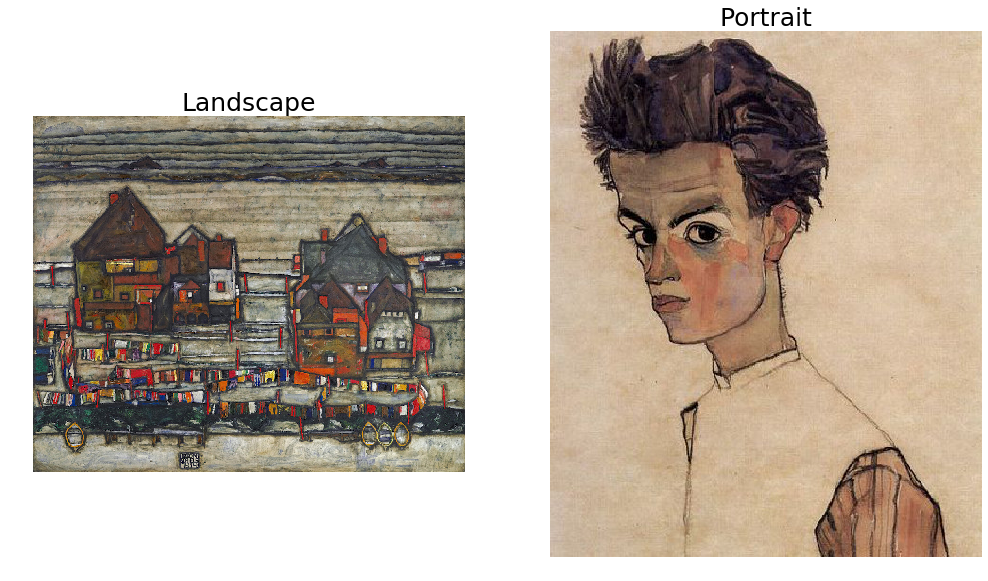

In [3]:
# Load the images
I1 = imread('data/schiele.jpg').astype(np.float64) / 256
I2 = imread('data/schiele2.jpg').astype(np.float64) / 256

fig = plt.figure(figsize=(17, 30))

ax = fig.add_subplot(1, 2, 1)
ax.imshow(I1)
ax.set_title('Landscape', fontsize=25)
ax.axis('off')

ax = fig.add_subplot(1, 2, 2)
ax.imshow(I2)
ax.set_title('Portrait', fontsize=25)
ax.axis('off')

plt.show()

We will need to work with "matrices" instead of images. Since there are 3 colors, images have shape `(Width, Height, 3)`, and the corresponding matrices will have shape `(Width*Height, 3)`.

In [6]:
I1.shape

(878, 1063, 3)

In [7]:
shape = (878, 1063, 3)

In [5]:
I1.reshape((-1, 3)).shape

(933314, 3)

In [8]:
I1.reshape((-1, 3)).reshape(shape).shape

(878, 1063, 3)

In [9]:
def im2mat(I):
    '''Convert image I to matrix.'''
    # TODO
    X = I.reshape((-1, 3))
    return X

def mat2im(X, shape):
    '''Convert matrix X to image with shape 'shape'.'''
    # TODO
    I = X.reshape(shape)
    return I

X1 = im2mat(I1)
X2 = im2mat(I2)

In [10]:
X1.shape

(933314, 3)

In [11]:
X2.shape

(254549, 3)

Real images have way too many different colors, so we will need to subsample them. In order to do this, we use K-means over all the colors, and keep only the computed centroids. Note that using Mini Batch K-Means will speed the computations up.

In [20]:
from sklearn.cluster import MiniBatchKMeans

# Size of the subsampled point clouds
nbsamples = 1000

# TODO: run MiniBatchKMeans on image 1, with nbsamples clusters, and deduce the centroids X1_sampled and the weights w1
kmeans1 = MiniBatchKMeans(n_clusters=nbsamples, init_size=nbsamples).fit(X1)
X1_sampled = kmeans1.cluster_centers_
w1 = np.array([np.sum(kmeans1.labels_ == k) for k in range(nbsamples)])
w1 = w1/np.sum(w1)

# TODO: run MiniBatchKMeans on image 2, with nbsamples clusters, and deduce the centroids X2_sampled and the weights w2
kmeans2 = MiniBatchKMeans(n_clusters=nbsamples, init_size=nbsamples).fit(X2)
X2_sampled = kmeans1.cluster_centers_
w2 = np.array([np.sum(kmeans2.labels_ == k) for k in range(nbsamples)])
w2 = w2/np.sum(w2)

In [33]:
kmeans1.cluster_centers_.shape

(1000, 3)

Each image is represented by its "matrix", i.e. is seen as a point cloud $X \in \mathbb{R}^{N\times3}$ in the RGB color space, identified with $\mathbb{R}^3$. 

In [17]:
def showImageAsPointCloud(X, Y, w1, w2):
    '''Show the color palette associated with images X and Y.'''
    fig = plt.figure(figsize=(17,8))
    ax = fig.add_subplot(121, projection='3d')
    ax.set_xlim(0,1)
    ax.scatter(X[:,0], X[:,1], X[:,2], c=X, s=20000*w1, marker='o', alpha=0.4)
    ax.set_xlabel('R',fontsize=22)
    ax.set_xticklabels([])
    ax.set_ylim(0,1)
    ax.set_ylabel('G',fontsize=22)
    ax.set_yticklabels([])
    ax.set_zlim(0,1)
    ax.set_zlabel('B',fontsize=22)
    ax.set_zticklabels([])
    ax.set_title('Landscape Color Palette', fontsize=20)
    ax.grid(False)
    
    ax = fig.add_subplot(122, projection='3d')
    ax.set_xlim(0,1)
    ax.scatter(Y[:,0], Y[:,1], Y[:,2], c=Y, s=20000*w2, marker='o', alpha=0.4)
    ax.set_xlabel('R',fontsize=22)
    ax.set_xticklabels([])
    ax.set_ylim(0,1)
    ax.set_ylabel('G',fontsize=22)
    ax.set_yticklabels([])
    ax.set_zlim(0,1)
    ax.set_zlabel('B',fontsize=22)
    ax.set_zticklabels([])
    ax.set_title('Portrait Color Palette', fontsize=20)
    ax.grid(False)
    
    plt.show()

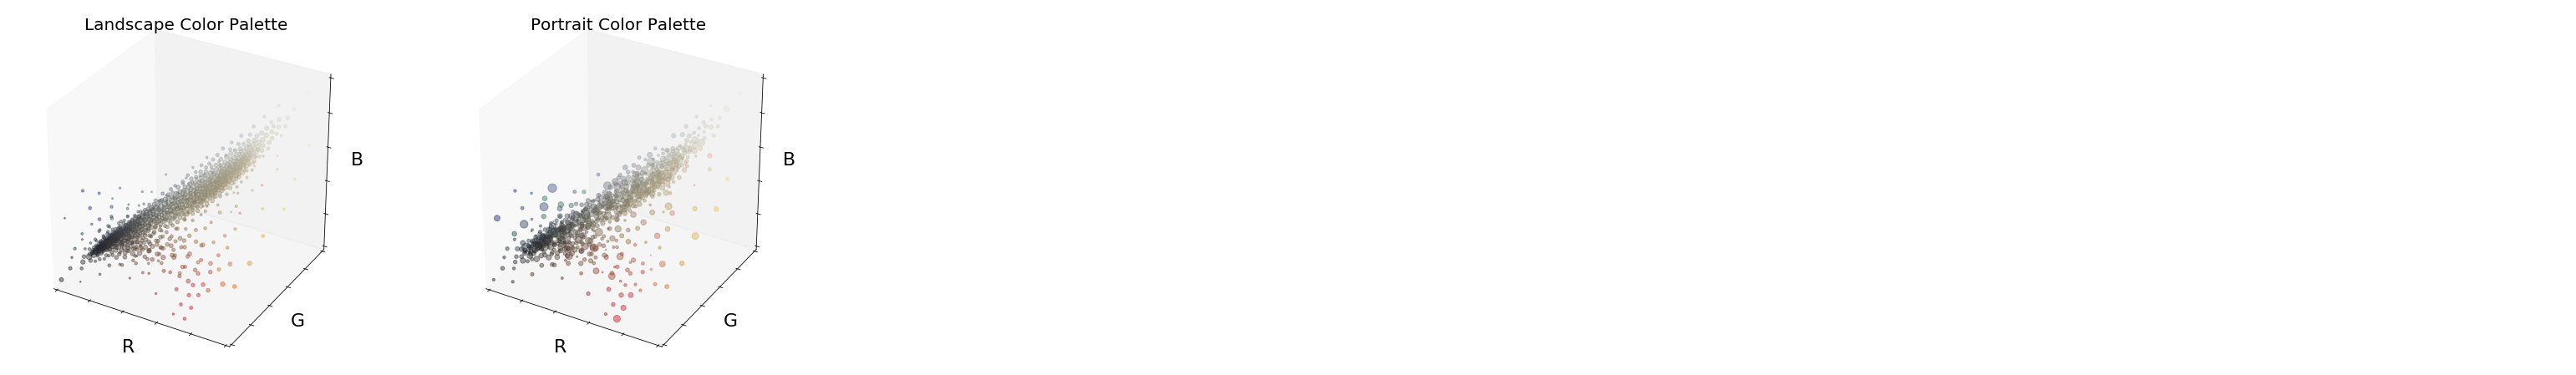

In [21]:
showImageAsPointCloud(X1_sampled, X2_sampled, w1, w2)

In order to compute the optimal transport plans between the two point clouds, we have to compute the corresponding cost matrix. In the following, we will always consider the squared distance, _i.e._ $C_{ij} = \|X_i - Y_j\|^2$.

In [41]:
C = np.linalg.norm(X1_sampled[:,None] - X2_sampled[None,:], axis=-1)# TODO: l2 cost between X1_sampled and X2_sampled

In [42]:
C.shape

(1000, 1000)

### Landscape with Portrait colors

Here, the goal is to transfer the colors of the portrait to the landscape. We will compute the exact Optimal Transport Plan, as well as the Entropy Regularized Optimal Transport plans.

In [44]:
regs = [0.01, 0.1, 0.5]
OT_plans = []
OT_plans.append(ot.emd(w1, w2, C))
OT_plans = [ot.sinkhorn(w1, w2, C, reg) for reg in regs] # List of OT plans for regularizations = 0, 0.01, 0.1, 0.5

In [46]:
OT_plans[0].shape

(1000, 1000)

In [47]:
kmeans1.cluster_centers_.shape

(1000, 3)

In [ ]:
def colorTransfer(OT_plan, kmeans1, kmeans2, shape):
    '''Return the color-transfered image of shape "shape".'''
    samples_transformed = OT_plan.dot(kmeans1.cluster_centers_)# TODO: Barycentric projection of the centroids
    X1_transformed = # TODO: transform each original pixel color
    return mat2im(X1_transformed, shape)# TODO: return an image, not a 3D point cloud

In [ ]:
fig = plt.figure(figsize=(17, 20))

ax = fig.add_subplot(1, 2, 1)
ax.imshow(I1)
ax.set_title('Source Image', fontsize=20)
ax.axis('off')

ax = fig.add_subplot(1, 2, 2)
I = colorTransfer(OT_plans[0], kmeans1, kmeans2, I1.shape)
ax.imshow(I)
ax.set_title('Reg = 0', fontsize=20)
ax.axis('off')

plt.show()

fig = plt.figure(figsize=(17, 20))
for i in range(3):
    ax = fig.add_subplot(2, 3, i+1)
    I = colorTransfer(OT_plans[i+1], kmeans1, kmeans2, I1.shape)
    ax.imshow(I)
    ax.set_title('Reg = '+str(regs[i]), fontsize=20)
    ax.axis('off')

plt.show()

### Portait with Landscape colors

We now transfer the colors of the landscape to the portrait.

In [ ]:
C = # TODO: transpose the cost

In [ ]:
regs = [0.01, 0.03, 0.1]
OT_plans = # List of OT plans for regularizations = 0, 0.01, 0.1, 0.5

In [ ]:
def colorTransfer(OT_plan, kmeans1, kmeans2, shape):
    samples_transformed = # TODO: Barycentric projection of the centroids
    X2_transformed = # TODO: transform each original pixel color
    return mat2im(X, shape) # TODO: return an image, not a 3D point cloud

In [ ]:
fig = plt.figure(figsize=(17, 20))

ax = fig.add_subplot(1, 2, 1)
ax.imshow(I2)
ax.set_title('Source Image', fontsize=20)
ax.axis('off')

ax = fig.add_subplot(1, 2, 2)
I = colorTransfer(OT_plans[0], kmeans1, kmeans2, I2.shape)
ax.imshow(I)
ax.set_title('Reg = 0', fontsize=20)
ax.axis('off')

plt.show()

fig = plt.figure(figsize=(17, 20))
for i in range(3):
    ax = fig.add_subplot(2, 3, i+1)
    I = colorTransfer(OT_plans[i+1], kmeans1, kmeans2, I2.shape)
    ax.imshow(I)
    ax.set_title('Reg = '+str(regs[i]), fontsize=20)
    ax.axis('off')

plt.show()

## 2. Document Clustering

We would likle to classify several text documents. In order to do this, we will:
1. Transform each text into a point cloud
2. Compute the Optimal Transport distances between each pair of point clouds
3. Use MDS to plot the different clusters in 2 dimensions

### Load the Data and Preprocessing
We consider seven movie scenarios. We transformed each of them into a point cloud using the following steps:
1. Keep only the words among the $2.000 - 20.000$ most common words
2. Each remaining word is transformed into a $300$-dimensional vector using word2vec
3. Each word is given a weight proportional to its frequency

The variable `texts` is a list of tuples. Each tuple represents a movie, and contains two parts:
1. A matrix $X \in \mathbb{R}^{n \times 300}$ where $n$ is the number of different words, containing the position of the points
2. A vector $a \in \mathbb{R}^n$ containing the corresponding weights

In [48]:
import pickle

with open('data/texts.pickle', 'rb') as file:
    texts = pickle.load(file)

movies = ['DUNKIRK', 'GRAVITY', 'INTERSTELLAR', 'KILL BILL VOL.1', 'KILL BILL VOL.2', 'THE MARTIAN', 'TITANIC']

In [52]:
len(texts)

7

In [60]:
texts[1][0].shape

(1203, 300)

In [61]:
texts[1][1].shape

(1203,)

### Compute the OT distances

In [49]:
# Set regularization strength
reg = 0.1

In [53]:
def costMatrix(i,j):
    '''Return the cost matrix C between movies number i and j.'''
    # TODO
    C = np.linalg.norm(texts[i][:,None] - texts[j][None, :], axis=-1)
    return C

In [54]:
OT_distances = np.zeros((7,7))
# TODO: OT_distances[i,j] should be the OT cost between movie i and movie j.
for i in range(7):
    for j in range(7):
        OT_distances[i,j] = ot.sinkhorn(a,b,costMatrix(i,j),reg)

In [ ]:
for film in movies:
    i = movies.index(film)
    print('The film most similar to', film, 'is', # TODO)

### Plot the MDS projection

In [ ]:
from sklearn.manifold import MDS
embedding = MDS(n_components=2, dissimilarity='precomputed')
dis = OT_distances - OT_distances[OT_distances>0].min()
np.fill_diagonal(dis, 0.)
embedding = embedding.fit(dis)
X = embedding.embedding_

import matplotlib.pyplot as plt
plt.figure(figsize=(17,6))
plt.scatter(X[:,0], X[:,1], alpha=0.)
plt.axis('equal')
plt.axis('off')
c = {'KILL BILL VOL.1':'red', 'KILL BILL VOL.2':'red', 'TITANIC':'blue', 'DUNKIRK':'blue', 'GRAVITY':'black', 'INTERSTELLAR':'black', 'THE MARTIAN':'black'}
for film in movies:
    i = movies.index(film)
    plt.gca().annotate(film, X[i], size=30, ha='center', color=c[film], weight="bold", alpha=0.7)
plt.show()